# This Notepad provides the code for ConsultingCorp's analysis for FoodCorp
Please read the associated report along with this code.

To run it you will need to fill in the database connection details in the cell below.

In [33]:
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import getpass

# =================================
# == Database connection details ==
#==================================
host = '10.158.72.112' # FILL IN [See the Data at Scale access instructions for your individual Database IP]
username = 'lixan23' # FILL IN
schema = 'ml2' # FILL IN [See the Data at Scale access instructions for your individual Database IP]
# =================================

password = getpass.getpass("Password for {}:".format(username))
dbname = 'nlab' 

if username == '' or username == None or password == '' or password == None or dbname == '' or dbname == None or host == '' or host == None:
    raise Exception('You MUST fill in the database connection details above')

Password for lixan23:········


# Statistic: Distribution of times between visit

In [58]:
sql_per_person_median = """
SELECT gap, SUM(ct) OVER(ORDER BY gap) / SUM(ct) OVER () AS cumulative, ct / SUM(ct) OVER () AS proportion
FROM (
    SELECT avg_gap::INT as gap, COUNT(*) as ct
    FROM (
        SELECT customer_id, percentile_cont(0.5) within group (order by (purchased_at-lag)) AS avg_gap 
        FROM (
            SELECT customer_id, purchased_at, lag(purchased_at,1) OVER (PARTITION BY customer_id ORDER BY purchased_at ASC)
            FROM (SELECT DISTINCT customer_id, purchased_at::DATE FROM {0}.receipts) x
        ) y
        -- Only measure gaps between visits, not between the first visit and nothing
        WHERE NOT lag is NULL
        GROUP BY 1) q
    GROUP BY 1
    ORDER BY 1
) y
ORDER BY gap
""".format(schema)


def y2x_val( y, d ):
    return d[np.argmin(np.abs(np.asarray(d[:,1],dtype=float)-y )),0]
  
def y2x_idx( y, d ):
    return np.argmin(np.abs(np.asarray(d[:,1],dtype=float)-y ))

def colour_bg_by_percent(ax, d, list_of_percents ):
    cur_x_ticks = set(ax.get_xticks())
    percent_bounds = zip([0.0]+list_of_percents,list_of_percents+[1.0])
    colours = sns.color_palette("Blues")
    
    percent_ticks = []
    
    plotted = []
    
    for i, pc in enumerate(percent_bounds):
        start = y2x_val(pc[0],d)
        end = y2x_val(pc[1],d)
        ax.axvspan(start, end, facecolor=colours[i], alpha=0.5)
        # Don't keep xticks that might overlap with the labels
        # we are going to put for the % changes
        cur_x_ticks.discard(start) 
        for j in range(10):
            cur_x_ticks.discard(start+j)
            cur_x_ticks.discard(start-j)
        percent_ticks += [start]
        
    
    cur_x_ticks = sorted(list(cur_x_ticks)+percent_ticks)
    ax.set_xticks(cur_x_ticks)
    
    return percent_ticks

def plot_fig(ax, bg_percents, sql, title):
    
    cur.execute(sql)
    data = np.asarray(cur.fetchall())    
    
    ax.plot(data[:,0],data[:,1], color = 'k')
    ax.set_xlim([0,y2x_idx( 0.90,data )])

    percent_ticks = colour_bg_by_percent(ax, data, bg_percents )    
    ax.set_xlabel('Days between visits')
    ax.set_ylabel('Cumulative % of customers')
    ax.set_title(title)
    return data, percent_ticks


# Statistic: target class proportions


In [35]:
# Be careful in this SQL to prevent judging people as churned
# when with simply do not have enough future "history" to see if they have
# returned. This is prevented by the line: WHERE '{2}'::DATE - at_date > churn_period
# I.e. for each definition of churn (x days of inactivity) we only consider data up
# to x days before the end of our data set (but use the full dataset to check if 
# churn occurred)
sql="""
SELECT churn_period, AVG(proportion) AS avg_prop, AVG(churned) AS avg_churned
FROM (
    SELECT churn_period, at_date, SUM(churned)::NUMERIC/COUNT(*)::NUMERIC AS proportion, SUM(churned) as churned
    FROM (
        SELECT  churn_period, 
                customer_id, 
                at_date, 
                -- Is the next date to far in the future (i.e. greater than the inactivity period that defines the churn label)?
                -- If so we have churned. Alternatively if the value is null then the customer never returned. 
                -- As long as there is enough future in our data set (guarenteed by (**)) then this also means we've churned.
                CASE WHEN (next_date is NULL)  OR (next_date - at_date) >= churn_period THEN 1 ELSE 0 END AS churned
        -- The select select from a table where:
        -- For each distinct customer_id, purchase_date record peak forward and attach to the record the next purchase date
        -- then replicate each line n times where n is the number of churn periods, i.e. create a duplicate for each churn 
        -- period of interest and append that churn period as an extra field (label it with that churn value)
        FROM (
            SELECT customer_id, purchased_at AS at_date, LEAD(purchased_at,1) OVER (PARTITION BY customer_id ORDER BY purchased_at ASC) AS next_date
            FROM (SELECT customer_id, purchased_at::DATE FROM {0}.receipts GROUP BY 1,2) a
        ) b, ( select unnest(array{1}) AS churn_period ) f
    ) d
    -- (**) Only keep records where at_date (the date of the first purchase, not the second)
    --      is far enough away from the end of our data set
    WHERE '{2}'::DATE - at_date > churn_period
    GROUP BY 1,2
) e
GROUP BY 1
"""
with psycopg2.connect("host='{}' dbname='{}' user='{}' password='{}'".format(host, dbname, username,password)) as conn:
#conn.set_session(autocommit=True)
    cur = conn.cursor()
    cur.execute("SELECT MAX(purchased_at)::DATE FROM {}.receipts".format(schema))
    maxdate = cur.fetchall()[0][0]

# Plot Figure 1 and Figure 2

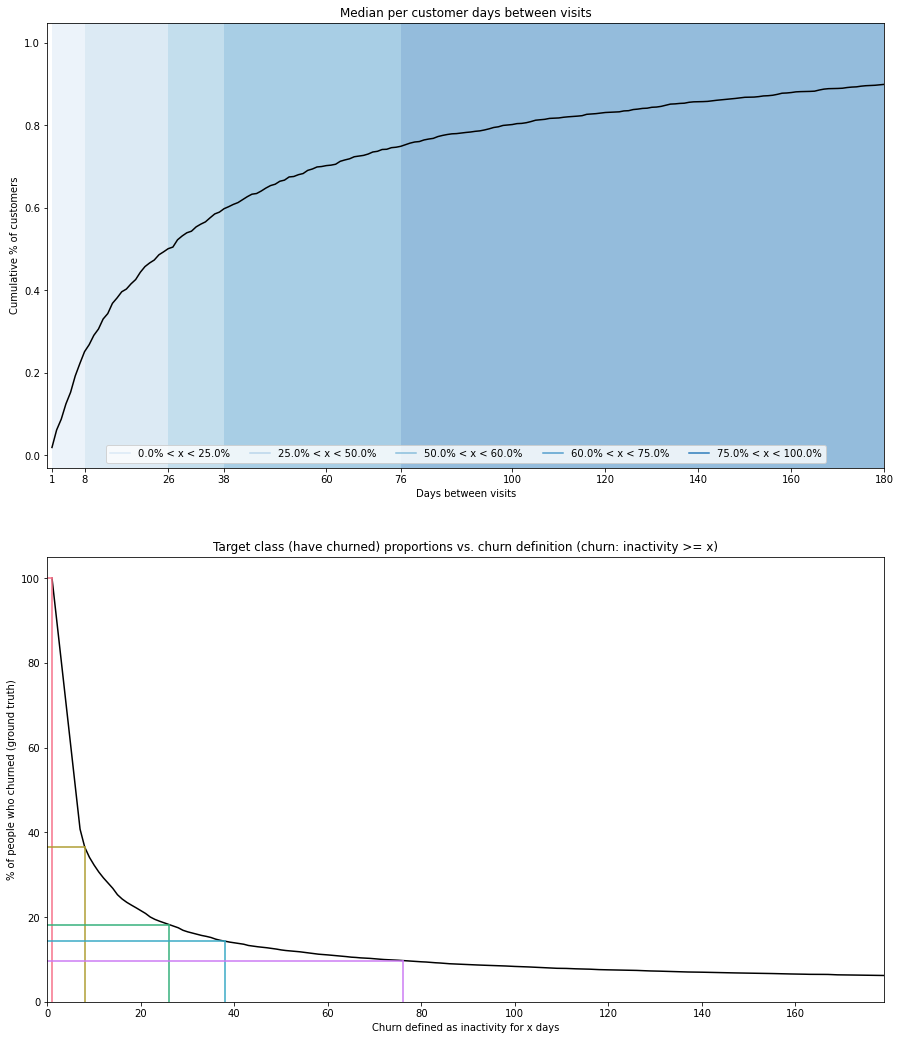

In [36]:
# ==============================
# ====== CELL PARAMETERS =======
# ==============================
bg_percents = [0.25,0.5,0.6,0.75] # ALTER THIS TO CHANGE WHAT THE BACKGROUND COLOURS HIGHLIGHTS
label_y = []#[0.1,0.11] # as a decimal percent, i.e. [0.1]
label_x = [] # [14,25,40,30,55]
include_percentage_bands_x_values_in_label_x = True
# ==============================

f, ax = plt.subplots(2, 1,figsize=(15, 20))

# Create the first plot
data_median, percent_ticks = plot_fig(ax[0],bg_percents, sql_per_person_median, 'Median per customer days between visits')

if include_percentage_bands_x_values_in_label_x:
    label_x += percent_ticks

churn_defs = list(sorted(set([ x for x in range(7,180)] + label_x)))

cur.execute(sql.format(schema,str(churn_defs),maxdate))
data2 = np.asarray(sorted(cur.fetchall()))
data2dict = dict(zip( data2[:,0], data2[:,1]))


plotted = [] # we need this for the legend, we'll draw off screen some dots.
for i in range(len(bg_percents)+1):
    plotted += plt.plot(1000,-1,color = sns.color_palette("Blues")[i])
ax[0].legend( plotted, ['{}% < x < {}%'.format(x[0]*100,x[1]*100) for x in zip([0.0]+bg_percents,bg_percents+[1.0])], loc = 'lower center', ncol=5, labelspacing=0. )
plt.gcf().subplots_adjust(bottom=0.2)

ax[1].plot(data2[:,0],data2[:,1]*100, color = 'k')
ax[1].set_xlim((min(data2[:,0]),max(data2[:,0])))
ax[1].set_xlabel('Churn defined as inactivity for x days')
ax[1].set_ylabel('% of people who churned (ground truth)')
ax[1].set_title('Target class (have churned) proportions vs. churn definition (churn: inactivity >= x)')
ax[1].set_ylim((0,ax[1].get_ylim()[1]))
ax[1].set_xlim((0,ax[1].get_xlim()[1]))
labels = []

colours = sns.color_palette("husl",len(label_y)+len(label_x))

for i, x in enumerate(label_x):
    ax[1].axvline(x=x, ymax = float(100*data2dict[x])/ax[1].get_ylim()[1], color = colours[i] )
    ax[1].axhline(y=100*data2dict[x], xmax = x/ax[1].get_xlim()[1], color = colours[i] )

for i, y in enumerate(label_y):
    ax[1].axvline(x=y2x_val( y, data2 ), ymax = (y*100)/ax[1].get_ylim()[1], color = colours[i+len(label_x)] )
    ax[1].axhline(y=y*100, xmax = y2x_val( y, data2 )/ax[1].get_xlim()[1], color = colours[i+len(label_x)]  )



# Plot Figure 3 content

In [37]:
# ==============================
# ====== CELL PARAMETERS =======
# ==============================
selected_days_set = [] + percent_ticks
# ==============================
for selected_days in selected_days_set:
    datadict1 = dict(zip( data_median[:,0], data_median[:,1]))
    datadict2 = dict(zip( data2[:,0], data2[:,1]))
    datadict3 = dict(zip( data2[:,0], data2[:,2]))
    y1 = datadict1[selected_days]
    y2 = datadict2[selected_days]
    y3 = datadict3[selected_days]
    print('Churn definition: {} days\n  --> {:.2f}% of customers median days between visits is less than this\n  --> We expect to be targetting {:.2f}% of active people ({:.2f} per prediction day on average) if our classifier is 100% correct.'.format(selected_days,y1*100,y2*100, y3))

Churn definition: 1 days
  --> 1.93% of customers median days between visits is less than this
  --> We expect to be targetting 100.00% of active people (68.75 per prediction day on average) if our classifier is 100% correct.
Churn definition: 8 days
  --> 25.14% of customers median days between visits is less than this
  --> We expect to be targetting 36.50% of active people (25.02 per prediction day on average) if our classifier is 100% correct.
Churn definition: 26 days
  --> 50.11% of customers median days between visits is less than this
  --> We expect to be targetting 18.23% of active people (12.40 per prediction day on average) if our classifier is 100% correct.
Churn definition: 38 days
  --> 59.79% of customers median days between visits is less than this
  --> We expect to be targetting 14.29% of active people (9.67 per prediction day on average) if our classifier is 100% correct.
Churn definition: 76 days
  --> 74.92% of customers median days between visits is less than thi

# Creating chart for cumulative sales

In [80]:
# Revise the code - matching customer id with their average gap and spending
# Calculate sale contribution with gap 
# Arrange in sale cumulative with increase in gap
sql_accumulate_sale = """
SELECT gap, SUM(sales) OVER(ORDER BY gap) / SUM(sales) OVER () AS cumulative, sales / SUM(sales) OVER () AS proportion
FROM (
    WITH 
    avg_gap as(
    SELECT customer_id, percentile_cont(0.5) within group (order by (purchased_at-lag)) AS avg_gap 
            FROM (
                SELECT customer_id, purchased_at, lag(purchased_at,1) OVER (PARTITION BY customer_id ORDER BY purchased_at ASC)
                FROM (SELECT DISTINCT customer_id, purchased_at::DATE FROM ml2.receipts_clean) x
            ) y
            WHERE NOT lag is NULL
            GROUP BY 1),
    indi_spend as (
    SELECT customer_id, sum(value) AS spend
    FROM ml2.receipts_clean
    JOIN ml2.receipt_lines_clean
    USING (receipt_id)
    GROUP BY 1)
    SELECT avg_gap::INT as gap, SUM(spend) as sales
    FROM avg_gap
    JOIN indi_spend
    USING (customer_id)
    GROUP BY 1
    ORDER BY 1
) y
ORDER BY gap
""".format(schema)


def y2x_val( y, d ):
    return d[np.argmin(np.abs(np.asarray(d[:,1],dtype=float)-y )),0]
  
def y2x_idx( y, d ):
    return np.argmin(np.abs(np.asarray(d[:,1],dtype=float)-y ))

def colour_bg_by_percent(ax, d, list_of_percents ):
    cur_x_ticks = set(ax.get_xticks())
    percent_bounds = zip([0.0]+list_of_percents,list_of_percents+[1.0])
    colours = sns.color_palette('Blues')
    
    percent_ticks = []
    
    plotted = []
    
    for i, pc in enumerate(percent_bounds):
        start = y2x_val(pc[0],d)
        end = y2x_val(pc[1],d)
        ax.axvspan(start, end, facecolor=colours[i], alpha=0.5)
        # Don't keep xticks that might overlap with the labels
        # we are going to put for the % changes
        cur_x_ticks.discard(start) 
        for j in range(10):
            cur_x_ticks.discard(start+j)
            cur_x_ticks.discard(start-j)
        percent_ticks += [start]
        
    
    cur_x_ticks = sorted(list(cur_x_ticks)+percent_ticks)
    ax.set_xticks(cur_x_ticks)
    
    return percent_ticks

def plot_fig(ax, bg_percents, sql, title):
    
    cur.execute(sql)
    data = np.asarray(cur.fetchall())    
    
    ax.plot(data[:,0],data[:,1], color = 'k')
    ax.set_xlim([0,y2x_idx( 0.90,data )])

    percent_ticks = colour_bg_by_percent(ax, data, bg_percents )    
    ax.set_xlabel('Days between visits')
    ax.set_ylabel('Cumulative % of sales')
    ax.set_title(title)
    return data, percent_ticks


In [61]:
# Getting the data
with psycopg2.connect("host='{}' dbname='{}' user='{}' password='{}'".format(host, dbname, username,password)) as conn:
    cur = conn.cursor()
    cur.execute(sql_accumulate_sale)
    gap_sales = cur.fetchall()
import pandas as pd
gap_sales=pd.DataFrame(gap_sales)  

In [65]:
# Finding respective values with gap used in first 2 charts
print(gap_sales[gap_sales[0]==1])
print(gap_sales[gap_sales[0]==8])
print(gap_sales[gap_sales[0]==26])
print(gap_sales[gap_sales[0]==38])
print(gap_sales[gap_sales[0]==78])

   0                       1                       2
0  1  0.13011231274619891504  0.13011231274619891504
   0                       1                       2
7  8  0.73530995635209772244  0.02607036063851422046
     0                       1                       2
25  26  0.90473427971941210826  0.00208144401622117599
     0                       1                       2
37  38  0.93407015019027023310  0.00258861968803647551
     0                       1                       2
76  78  0.96835971263961604313  0.00048804401327099381


(0.0, 1.0)

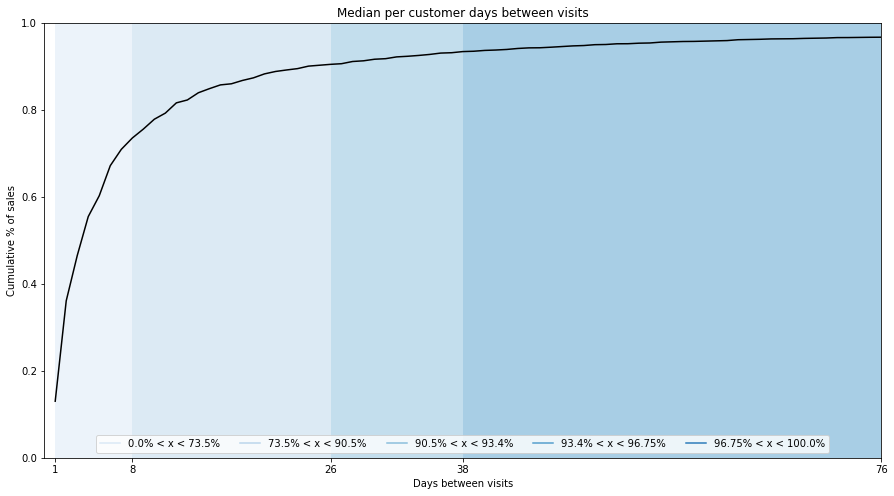

In [81]:
#Plot the first chart gain with sales
bg_percents = [0.735,0.905,0.934,0.9675] # ALTER THIS TO CHANGE WHAT THE BACKGROUND COLOURS HIGHLIGHTS

f, ax = plt.subplots(figsize=(15, 8))

# Create the first plot
plot_fig(ax,bg_percents, sql_accumulate_sale, 'Median per customer days between visits')


plotted = [] # we need this for the legend, we'll draw off screen some dots.
for i in range(len(bg_percents)+1):
    plotted += plt.plot(1000,-1,color = sns.color_palette("Blues")[i])
ax.legend( plotted, ['{}% < x < {}%'.format(x[0]*100,x[1]*100) for x in zip([0.0]+bg_percents,bg_percents+[1.0])], loc = 'lower center', ncol=5, labelspacing=0. )
ax.set_ylim([0,1])